## Model Selection for dataset without food

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [3]:
from itertools import combinations
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [4]:
from collab_env.gnn.gnn import get_adjcency_from_debug, plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets, static_visualize_2sets

from collab_env.gnn.utility import dataset2testloader
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from itertools import product

In [5]:
torch.cuda.empty_cache()

In [6]:
data_names = ['boid_single_species_basic','boid_single_species_independent'] #'runpod/boid_single_species_basic']

data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

              #'boid_single_species_weak_alignment',
              #'boid_single_species_strong_alignment']#, 'boid_single_species_independent', # without food
              #'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              #'boid_food_strong'] # with food, strong influence

model_names = ["vpluspplus_a"]
noise_levels = [0,0.005]
heads = [1]
visual_ranges = [0.5]
seeds = [0,1,2,3,4]

all_combinations = list(product(data_names, model_names, noise_levels, heads, visual_ranges, seeds))


In [7]:
rollout_results =  {}
data = {}
model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s = all_combinations[ind]

    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": True
    }
    
    data_name_short = data_names_short[data_name]
    model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    try:
        
        rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
        model_names[ind] = model_save_name
        print(f"Successfully import {model_save_name}")
    except:
        print(f"Cannot import {model_save_name}")


/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0_h1_vr0.5_s0_rollout5.pkl
Successfully import boid_
n0_h1_vr0.5_s0
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0_h1_vr0.5_s1_rollout5.pkl
Successfully import boid_
n0_h1_vr0.5_s1
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0_h1_vr0.5_s2_rollout5.pkl
Successfully import boid_
n0_h1_vr0.5_s2
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0_h1_vr0.5_s3_rollout5.pkl
Successfully import boid_
n0_h1_vr0.5_s3
/workspace/collab-environment/trained_models/runpod/boid_single_species_basic/rollouts/boid_single_species_basic_vpluspplus_a_n0_h1_vr0.5_s4_rollout5.pkl
Cannot import boid_
n0_h1_vr0.5_s4
/workspace/collab-environment/t

In [9]:
def sqr_diff(pred, actual):
    return np.sqrt(np.sum((pred - actual) ** 2, axis = 2))

In [10]:
def return_mse(rollout_result, starting_frame, end_frame):
    
    F = len(rollout_result[0]['predicted']) #frames
    mse_by_frame = []
    for f in range(starting_frame, end_frame):
        Sqrdiff = []
        for b in [0,1]:#rollout_result:
            pred = rollout_result[b]['predicted'][f]
            actual = rollout_result[b]['actual'][f]
            Sqrdiff.append(sqr_diff(pred, actual))

        Sqrdiff = np.mean(np.concatenate(Sqrdiff, axis = 0))
        mse_by_frame.append(Sqrdiff)
    return mse_by_frame

### Does noise help rollout?

In [11]:
import pandas as pd
import seaborn as sns

Text(0.5, 1.0, 'Independent dataset')

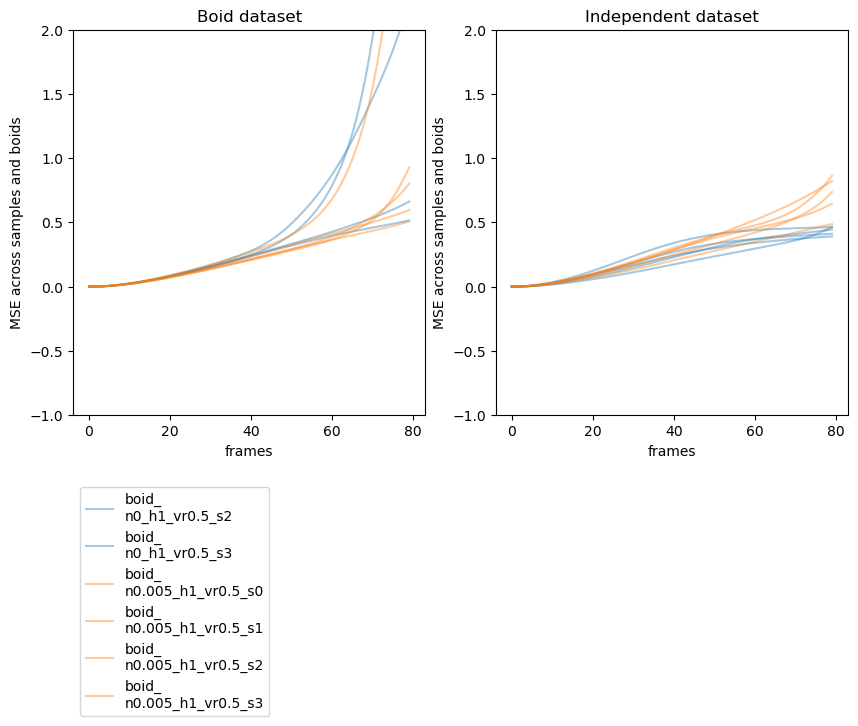

In [12]:
starting_frame = 0
end_frame = 80

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(10, 5))

mse_by_frame_all = []
mse_by_frame_all_dict = {} #fool-proof

for m in rollout_results:
    if "idpnt" in model_names[m]:
        ax = axes[1]
    else:
        ax = axes[0]
    if "n0.005" in model_names[m]:
        c = 'C1'
    else:
        c = 'C0'
    mse_by_frame = return_mse(rollout_results[m][0], starting_frame, end_frame)
    mse_by_frame_all.append(mse_by_frame)
    if mse_by_frame[60] <= 0.5:
        label = model_names[m]
    else:
        label = None
    ax.plot(mse_by_frame, label = label, alpha = 0.4, color = c)
    mse_by_frame_all_dict[m] = np.sum(mse_by_frame)

for ax in axes:
    ax.set_ylim([-1,2])
    ax.set_xlabel('frames')
    ax.set_ylabel('MSE across samples and boids')

axes[0].legend(bbox_to_anchor=(0, -0.8), loc='lower left')
axes[0].set_title("Boid dataset")
axes[1].set_title("Independent dataset")

In [19]:
mse_noise_idpnt, mse_nonoise_idpnt = [], []
mse_noise_boid, mse_nonoise_boid = [], []

for m in rollout_results:
    mse_ = np.log(mse_by_frame_all_dict[m])
    
    if "n0.005" in model_names[m]:
        if "boid" in model_names[m]:
            mse_noise_boid.append(mse_)
        elif "idpnt" in model_names[m]:
            mse_noise_idpnt.append(mse_)
    else:
        if "boid" in model_names[m]:
            mse_nonoise_boid.append(mse_)
        elif "idpnt" in model_names[m]:
            mse_nonoise_idpnt.append(mse_)

In [20]:
rollout_results.keys()

dict_keys([0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

/tmp/ipykernel_3422/455030894.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Value', data=df, palette=my_pal)


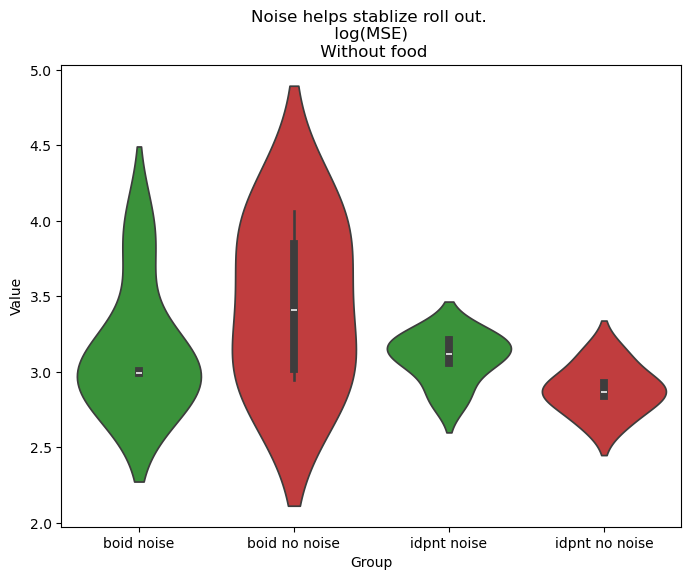

In [22]:
# Create a DataFrame with groups of different lengths
data = {
    'boid noise': mse_noise_boid,
    'boid no noise': mse_nonoise_boid,
    'idpnt noise': mse_noise_idpnt,
    'idpnt no noise': mse_nonoise_idpnt,
}

my_pal = {}
my_pal['boid noise'] = 'C2'
my_pal['boid no noise'] = 'C3'
my_pal['idpnt noise'] = 'C2'
my_pal['idpnt no noise'] = 'C3'

# Convert to long-form for seaborn
df_list = []
for group, values in data.items():
    df_list.append(pd.DataFrame({'Value': values, 'Group': group}))
df = pd.concat(df_list)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Group', y='Value', data=df, palette=my_pal)
plt.title('Noise helps stablize roll out. \n log(MSE) \n Without food')
plt.show()

In [23]:
mse_by_frame_np = np.array(mse_by_frame_all)
rollout_results_names = list(rollout_results.keys())

# produce top model names:
indices = np.argsort(mse_by_frame_np[:,-1])[:20] #pick top 10
top_names = [model_names[rollout_results_names[ind]] for ind in indices]
print("top models:", top_names)

print("\n")

# produce bad model names:
indices = np.argsort(mse_by_frame_np[:,-1])[-10:] #pick top 10
top_names = [model_names[rollout_results_names[ind]] for ind in indices]
print("bottom models:", top_names)

top models: ['idpnt_\nn0_h1_vr0.5_s0', 'idpnt_\nn0_h1_vr0.5_s4', 'idpnt_\nn0_h1_vr0.5_s3', 'idpnt_\nn0_h1_vr0.5_s2', 'idpnt_\nn0_h1_vr0.5_s1', 'idpnt_\nn0.005_h1_vr0.5_s3', 'boid_\nn0.005_h1_vr0.5_s2', 'boid_\nn0_h1_vr0.5_s2', 'boid_\nn0.005_h1_vr0.5_s1', 'idpnt_\nn0.005_h1_vr0.5_s4', 'boid_\nn0_h1_vr0.5_s3', 'idpnt_\nn0.005_h1_vr0.5_s0', 'boid_\nn0.005_h1_vr0.5_s3', 'idpnt_\nn0.005_h1_vr0.5_s2', 'idpnt_\nn0.005_h1_vr0.5_s1', 'boid_\nn0.005_h1_vr0.5_s0', 'boid_\nn0_h1_vr0.5_s0', 'boid_\nn0.005_h1_vr0.5_s4', 'boid_\nn0_h1_vr0.5_s1']


bottom models: ['idpnt_\nn0.005_h1_vr0.5_s4', 'boid_\nn0_h1_vr0.5_s3', 'idpnt_\nn0.005_h1_vr0.5_s0', 'boid_\nn0.005_h1_vr0.5_s3', 'idpnt_\nn0.005_h1_vr0.5_s2', 'idpnt_\nn0.005_h1_vr0.5_s1', 'boid_\nn0.005_h1_vr0.5_s0', 'boid_\nn0_h1_vr0.5_s0', 'boid_\nn0.005_h1_vr0.5_s4', 'boid_\nn0_h1_vr0.5_s1']


### Conclusion

Given the noised version for boid is better we select the following models:

'boid_\nn0.005_h1_vr0.5_s2' 'idpnt_\nn0.005_h1_vr0.5_s3'